# Base Model (Linear Regression)
This base model will be used to benchmark subsequent ML/Non-ML models. This base model uses Muli-variate Linear Regression to predict the target course demand.

This model is trained on the Final Enrollment Status Data, which is a filtered version of the original Enrollment Dataset.

In [1]:
# importing the required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir( os.path.join("..", "..", "..") )

# importing custom modules
from Code.src.modules.db_ops import *
from Code.src.modules.dataManager import DataManager
from Code.src.modules.eda import *

# initializing the DataManager
DM = DataManager()

In [2]:
# importing the data for analysis
df = DM.get_data('EnrollmentFinalStatus', 'pkl', 'processed')
db = DM.get_data('EnrollmentFinalStatus', 'db', 'processed')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59409 entries, 0 to 323686
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rec_id               59409 non-null  int64         
 1   rec_ext_date         59409 non-null  datetime64[ns]
 2   file_name            59409 non-null  object        
 3   file_index           59409 non-null  int64         
 4   reg_term_code        59409 non-null  object        
 5   reg_term_year        59409 non-null  int64         
 6   reg_term_name        59409 non-null  category      
 7   reg_term_desc        59409 non-null  object        
 8   stu_id               59408 non-null  object        
 9   stu_deg_level        59409 non-null  category      
 10  stu_college          59409 non-null  category      
 11  stu_res              59409 non-null  category      
 12  stu_visa             59409 non-null  category      
 13  stu_bam              59409 non

## Exploratory Data Analysis

### Top Waitlisted Courses by Number of Students

In [3]:
# Pick a program to analyze
df.stu_prog_desc.unique().tolist()

['MS Information Systems',
 'MS Infrmatn Security & Assrnce',
 'MS Civil & Infrastructure Engr',
 'MS Software Engineering',
 'MS Computer Science',
 'MS Computer Forensics',
 'MS Computer Engineering',
 'MS Systems Engineering',
 'MS Applied Info Technology',
 'MS Telecommunications',
 'MS Data Analytics Engineering',
 'MS Electrical Engineering',
 'MS Operations Research',
 'MS Statistical Science',
 'MS Biostatistics',
 'MENG GeoConStruct Engineering',
 'MS Bioengineering',
 'MS Cyber Security Engineering',
 'MS Digital Forensics']

In [4]:
# Choose a program here, and the criteria to sort ["pct", "num"]
prog_desc, criteria = "all", "num" # <-- CHANGE THESE VALUES AND RERUN THE BELOW CELLS

cond = "--" if prog_desc.lower() == "all" else ""
criteria = "pct_waitlisted" if criteria.lower() == "pct" else "num_waitlisted"

In [5]:
query = db.runQuery(f""" --sql
    SELECT stu_prog_desc, crs, num_registered, num_waitlisted, num_waitlisted*100/(num_registered+num_waitlisted) as pct_waitlisted
    FROM 
        (SELECT
            stu_prog_desc, crs,
            COUNT(CASE WHEN reg_status IN ("**Web Registered**", "**Registered**") THEN 1 END) as num_registered,
            COUNT(CASE WHEN reg_status IN ("Wait Listed") THEN 1 END) as num_waitlisted
        FROM enrollmentFinalStatus
        {cond} WHERE stu_prog_desc = "{prog_desc}"
        GROUP BY crs
        ORDER BY num_waitlisted DESC)
    ORDER BY {criteria} DESC
    LIMIT 10;
""")
query

,stu_prog_desc,crs,num_registered,num_waitlisted,pct_waitlisted
0,MS Computer Science,CS 583,1214,265,17
1,MS Data Analytics Engineering,CS 504,1739,232,11
2,MS Computer Science,CS 580,1004,227,18
3,MS Computer Science,SWE 642,655,224,25
4,MS Computer Engineering,SWE 621,793,218,21
5,MS Computer Science,CS 695,490,216,30
6,MS Software Engineering,CS 550,1307,212,13
7,MS Computer Science,CS 584,1004,202,16
8,MS Software Engineering,SWE 645,678,191,21
9,MS Infrmatn Security & Assrnce,SWE 619,686,167,19


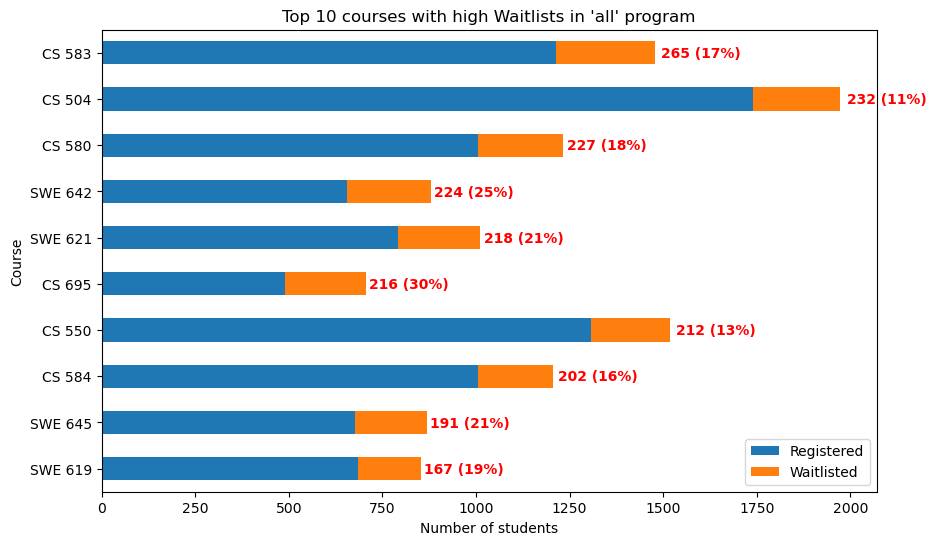

In [6]:
# Plotting stacked horizontal bar chart for the top 10 courses
fig, ax = plt.subplots(figsize=(10, 6))

query.plot.barh(x="crs", y=["num_registered", "num_waitlisted"], stacked=True, ax=ax)

ax.invert_yaxis()

for i, v in enumerate(query.num_waitlisted):
    ax.text(
        query[['num_waitlisted', 'num_registered']].sum(axis=1)[i]*1.01, i+0.1,
        str(v)+" ("+str(query.pct_waitlisted[i])+"%)", color='red', fontweight='bold'
    )

ax.set_title(f"Top 10 courses with high Waitlists in '{prog_desc}' program")
ax.set_xlabel("Number of students")
ax.set_ylabel("Course")
ax.legend(["Registered", "Waitlisted"], loc="lower right")

plt.show()

### Plotting the Course Demand for a course
$$\rm{Course Demand} = \rm{Web Registered} + \rm{Registered} + \rm{Wait Listed}$$

In [7]:
crs, term = "CS 504", "Fall"
cond = "--" if term.lower() == "all" else ""

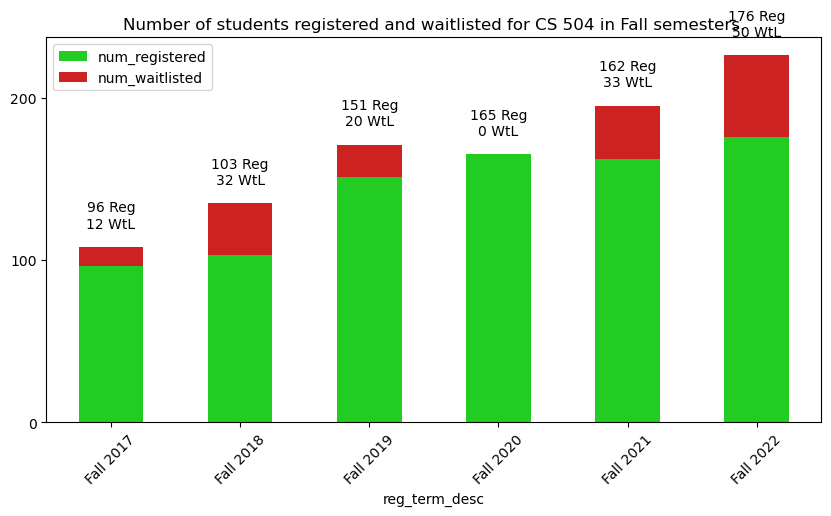

In [8]:
# Plotting the number of students registered and waitlisted for a course in a term

query = db.runQuery(f""" --sql
    SELECT
        reg_term_code, reg_term_desc, crs,
        COUNT(CASE WHEN reg_status IN ("**Web Registered**", "**Registered**") THEN 1 END) as num_registered,
        COUNT(CASE WHEN reg_status IN ("Wait Listed") THEN 1 END) as num_waitlisted
    FROM enrollmentFinalStatus
    WHERE
        crs = "{crs}"
        {cond} AND reg_term_name = "{term}"
        -- AND stu_prog_code IN ("VS-MS-DAEN", "EC-MS-DAEN")
    GROUP BY reg_term_code, reg_term_desc, crs;
""")

# Create a stacked bar chart to show the number of students registered and waitlisted for a course in a term
query.plot.bar(
    x="reg_term_desc", y=["num_registered", "num_waitlisted"],\
    stacked=True, figsize=(10, 5), rot=0, color=["#22cc22", "#cc2222"]
)
plt.yticks(range(0, query["num_registered"].max()+100, 100))
plt.xticks(rotation=45)

# Adding labels to each bar
for i, row in query.iterrows():
    plt.text(
        i, row["num_registered"]+row["num_waitlisted"]+10, 
        f"{row['num_registered']} Reg\n{row['num_waitlisted']} WtL", 
        ha="center", va="bottom"
    )

plt.title(f"Number of students registered and waitlisted for {crs} in {term} semesters.")
plt.show()

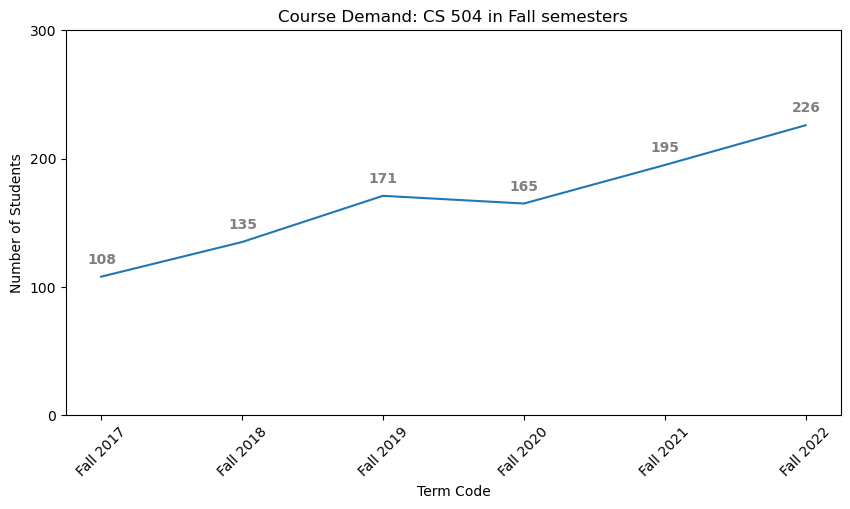

In [9]:
# Plotting the course demand for a course over the terms
query = db.runQuery(f""" --sql
    SELECT reg_term_code, reg_term_desc, crs, COUNT(stu_id) as num_students
    FROM enrollmentFinalStatus
    WHERE
        crs = "{crs}"
        {cond} AND reg_term_name = "{term}"
        AND reg_status IN ("**Web Registered**", "**Registered**", "Wait Listed")
    GROUP BY reg_term_code, reg_term_desc;
""")

query

# Plotting the line graph for number of students in each term
plt.figure(figsize=(10, 5))
plt.plot(query["reg_term_code"], query["num_students"])

plt.xticks(rotation=90)
# Rounding the y-axis to the upper 100
plt.yticks(range(0, query["num_students"].max()+100, 100))

for i, v in enumerate(query["num_students"]):
    plt.text(i-0.1, v+10, str(v), color='grey', fontweight='bold')
plt.xticks(query["reg_term_code"], query["reg_term_desc"], rotation=45)
plt.title(f"Course Demand: {crs} in {term} semesters")
plt.xlabel("Term Code")
plt.ylabel("Number of Students")

plt.show()

## Linear Regression Model
Training a Linear Regression model for the CS 504 courses as it has very high waitlist numbers in the Data Analytics Engineering program.

### Data Prep

In [10]:
# Setting the parameters for the model
crs = "CS 504"
# str_prog_desc = "MS Data Analytics Engineering"

In [11]:
# Querying the data for the model
df_lr = db.runQuery(f""" --sql
    SELECT reg_term_code, reg_term_desc, crs, COUNT(stu_id) as crs_demand
    FROM enrollmentFinalStatus
    WHERE
        crs = "{crs}"
        AND reg_status IN ("**Web Registered**", "**Registered**", "Wait Listed")
        AND reg_term_name IN ("Fall")
    GROUP BY reg_term_code, reg_term_desc, crs;
""")

# Creating a new column for the semester number, to be used as the predictor variable
df_lr["n_sem"] = df_lr.index + 1

df_lr

,reg_term_code,reg_term_desc,crs,crs_demand,n_sem
0,201770,Fall 2017,CS 504,108,1
1,201870,Fall 2018,CS 504,135,2
2,201970,Fall 2019,CS 504,171,3
3,202070,Fall 2020,CS 504,165,4
4,202170,Fall 2021,CS 504,195,5
5,202270,Fall 2022,CS 504,226,6


### Model Training
The Model is trained in the following steps:
1. Testing the applicability of Linear Regression Algorithm on the data
    1. Data Preprocessing
        1. Normalizing the data
    2. Training and Testing the model with Linear Regression Algorithm and Cross Validation
    3. Evaluating the model with RMSE
    4. Choosing the best model based on the RMSE
    5. Predicting the target values for the future semesters using the best model
    6. Exporting the results
        1. Exporting predictions for the future semesters
        2. Exporting the model
2. Training the model with Linear Regression Algorithm based on the results of step 1
    1. Data Preprocessing
        1. Normalizing the data
        2. Splitting the data into training and testing sets
    2. Training the model with Linear Regression Algorithm
    3. Predicting the target values for the future semesters
    4. Exporting the results
        1. Exporting predictions for the future semesters
        2. Exporting the model

In [12]:
# Importing the required libraries for training the model
from sklearn.preprocessing import normalize

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Normalizing the data


In [ ]:
# Training a LR Model to predict the crs_demand for the next semester using the n_sem as the predictor variable
from sklearn.linear_model import LinearRegression

X = df_lr[["n_sem"]]
y = df_lr["crs_demand"]

lr = LinearRegression()
lr.fit(X, y)

# Predicting the crs_demand for the next semester
n_sem = df_lr["n_sem"].max() + 1